# Severstal: Steel Defect Detection

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.vision import *

In [3]:
import fastai.utils
fastai.utils.show_install()



```text
=== Software === 
python        : 3.7.3
fastai        : 1.0.57
fastprogress  : 0.1.21
torch         : 1.2.0
nvidia driver : 435.21
torch cuda    : 10.0.130 / is available
torch cudnn   : 7602 / is enabled

=== Hardware === 
nvidia gpus   : 1
torch devices : 1
  - gpu0      : 16160MB | Tesla V100-SXM2-16GB

=== Environment === 
platform      : Linux-4.15.0-1047-aws-x86_64-with-debian-buster-sid
distro        : #49-Ubuntu SMP Fri Aug 23 09:02:45 UTC 2019
conda env     : base
python        : /home/ubuntu/anaconda3/bin/python
sys.path      : /home/ubuntu/kaggle_severstal
/home/ubuntu/anaconda3/lib/python37.zip
/home/ubuntu/anaconda3/lib/python3.7
/home/ubuntu/anaconda3/lib/python3.7/lib-dynload

/home/ubuntu/.local/lib/python3.7/site-packages
/home/ubuntu/anaconda3/lib/python3.7/site-packages
/home/ubuntu/anaconda3/lib/python3.7/site-packages/IPython/extensions
/home/ubuntu/.ipython
```

Please make sure to include opening/closing ``` when you paste into forums/github to make the

In [4]:
! pip install opencv-python

In [4]:
import cv2

In [5]:
path = Config.data_path()/'severstal-steel-defect-detection'
path.mkdir(parents=True, exist_ok=True)
path

PosixPath('/home/ubuntu/.fastai/data/severstal-steel-defect-detection')

## Getting the data

In [8]:
! {sys.executable} -m pip install kaggle --upgrade

Requirement already up-to-date: kaggle in /home/ubuntu/anaconda3/lib/python3.7/site-packages (1.5.6)


In [9]:
! mkdir -p ~/.kaggle/
! mv kaggle.json ~/.kaggle/

In [10]:
! kaggle competitions download -c severstal-steel-defect-detection -f train.csv -p {path}  
! kaggle competitions download -c severstal-steel-defect-detection -f train_images.zip -p {path}  
! kaggle competitions download -c severstal-steel-defect-detection -f test_images.zip -p {path}  
! unzip -q -n {path}/train_images.zip -d {path}/train_images
! unzip -q -n {path}/test_images.zip -d {path}/test_images
! unzip -q -n {path}/train.csv.zip -d {path}

  0%|                                               | 0.00/6.91M [00:00<?, ?B/s]
100%|██████████████████████████████████████| 6.91M/6.91M [00:00<00:00, 96.6MB/s]
100%|██████████████████████████████████████▉| 1.16G/1.16G [00:09<00:00, 149MB/s]
100%|███████████████████████████████████████| 1.16G/1.16G [00:09<00:00, 135MB/s]
 93%|██████████████████████████████████████▏  | 120M/129M [00:00<00:00, 120MB/s]
100%|█████████████████████████████████████████| 129M/129M [00:00<00:00, 162MB/s]


In [11]:
! chmod 555 '/home/ubuntu/.fastai/data/severstal-steel-defect-detection/train.csv'

## Setup

In [6]:
path_img = path/'train_images'

In [7]:
path_test = path/'test_images'

In [8]:
path_lbl = path/'labels'

## Data Ingestion

In [9]:
train_df = pd.read_csv(path/'train.csv')
train_df.head()

,ImageId_ClassId,EncodedPixels
0,0002cc93b.jpg_1,29102 12 29346 24 29602 24 29858 24 30114 24 3...
1,0002cc93b.jpg_2,NaN
2,0002cc93b.jpg_3,NaN
3,0002cc93b.jpg_4,NaN
4,00031f466.jpg_1,NaN


## Process labels

In [10]:
def process_csv(path, csv):
    
    train_df = pd.read_csv(path/csv)
    
    train_df['label'] = train_df.apply(lambda x : x['ImageId_ClassId'].split('_')[-1], axis=1)
    train_df['image_id'] = train_df.apply(lambda x : x['ImageId_ClassId'].split('_')[0], axis=1)

    proc_train_df = train_df.pivot(index='image_id', columns='label', values='EncodedPixels').reset_index(drop=False)

    proc_train_df = proc_train_df.fillna(value=' ')
    
    return proc_train_df

In [11]:
proc_train_df = process_csv(path, 'train.csv')

In [12]:
proc_train_df.head()

label,image_id,1,2,3,4
0,0002cc93b.jpg,29102 12 29346 24 29602 24 29858 24 30114 24 3...,,,
1,00031f466.jpg,,,,
2,000418bfc.jpg,,,,
3,000789191.jpg,,,,
4,0007a71bf.jpg,,,18661 28 18863 82 19091 110 19347 110 19603 11...,


In [19]:
## Save RLEs as PNGs

In [20]:
! mkdir '/home/ubuntu/.fastai/data/severstal-steel-defect-detection/labels'

In [21]:
def make_labels_rle(path, train, proc_train_df, labels):
    for index, row in proc_train_df.iterrows():
        save_rle_label_image(path, row, train, labels)

In [22]:
def save_rle_label_image(path, mask_df, train, labels):
    image_id, rles = mask_df[0], mask_df[1:]
    image_fn = re.search('(.*?)\.jpg', image_id).group(1)+'.png'
    shape = open_image(path/train/image_id).shape[-2:]
    final_mask = torch.zeros((1, *shape))
    for k, rle in enumerate(rles):
        if isinstance(rle, str):
            mask = open_mask_rle(rle, shape).px.permute(0, 2, 1)
            final_mask += (k+1)*mask
    mask_img = image2np(final_mask.data).astype(np.uint8)
    PIL.Image.fromarray(mask_img).save(path/labels/image_fn, 'png')

In [24]:
%%time 
make_labels_rle(path, 'train_images', proc_train_df, path_lbl)

CPU times: user 13min 24s, sys: 41.6 s, total: 14min 5s
Wall time: 3min 31s


## Explore 

In [13]:
get_y_fn = lambda x: (path_lbl/f'{x.stem}').with_suffix('.png')

In [14]:
fnames = get_image_files(path_img)
fnames[:5]

[PosixPath('/home/ubuntu/.fastai/data/severstal-steel-defect-detection/train_images/cf1152c44.jpg'),
 PosixPath('/home/ubuntu/.fastai/data/severstal-steel-defect-detection/train_images/b54038841.jpg'),
 PosixPath('/home/ubuntu/.fastai/data/severstal-steel-defect-detection/train_images/1c97d1861.jpg'),
 PosixPath('/home/ubuntu/.fastai/data/severstal-steel-defect-detection/train_images/6ac1d05d3.jpg'),
 PosixPath('/home/ubuntu/.fastai/data/severstal-steel-defect-detection/train_images/f0b2483fa.jpg')]

In [15]:
lbl_names = get_image_files(path_lbl)
lbl_names[:5]

[PosixPath('/home/ubuntu/.fastai/data/severstal-steel-defect-detection/labels/1863eb011.png'),
 PosixPath('/home/ubuntu/.fastai/data/severstal-steel-defect-detection/labels/62cf0b008.png'),
 PosixPath('/home/ubuntu/.fastai/data/severstal-steel-defect-detection/labels/1c2a39896.png'),
 PosixPath('/home/ubuntu/.fastai/data/severstal-steel-defect-detection/labels/8bfc35309.png'),
 PosixPath('/home/ubuntu/.fastai/data/severstal-steel-defect-detection/labels/e6207db1a.png')]

torch.Size([3, 256, 1600])


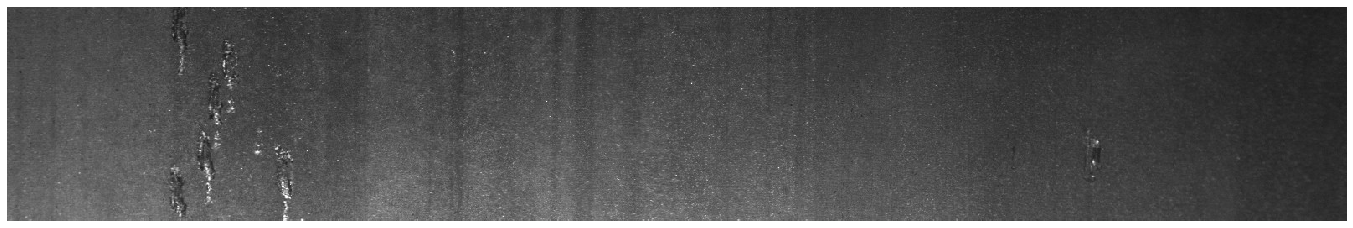

In [16]:
img_f = fnames[3]
img = open_image(img_f)
print(img.shape)
img.show(figsize=(24,24))

{0, 3}


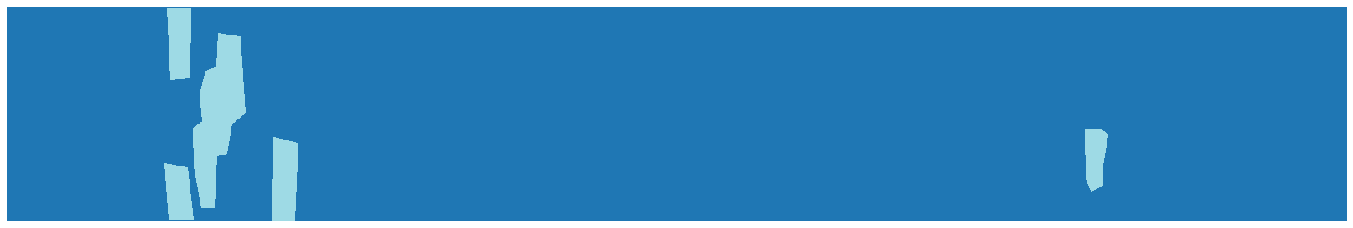

In [17]:
mask = open_mask(get_y_fn(img_f))
print(set(mask.data.numpy().flatten()))
mask.show(figsize=(24,24), alpha=1)

In [18]:
src_size = np.array(mask.shape[1:])
src_size, mask.data

(array([ 256, 1600]), tensor([[[0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          ...,
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0]]]))

## Setup Data Block

In [19]:
codes = [0,1,2,3,4]

In [20]:
from fastai.utils.mem import *
size = src_size//2

bs=40

wd=1e-2
print(size, bs, wd)

[128 800] 40 0.01


In [21]:
# Get to 400 wide
size = size//2
print(size)

[ 64 400]


In [22]:
# Get to 200 wide
size = size//2
print(size)

[ 32 200]


In [30]:
np.random.seed(42)
src = (SegmentationItemList.from_folder(path_img)
        .split_by_rand_pct(valid_pct=0.1)
        .label_from_func(get_y_fn, classes=codes))

In [31]:
data = (src.transform(get_transforms(), size=size, tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

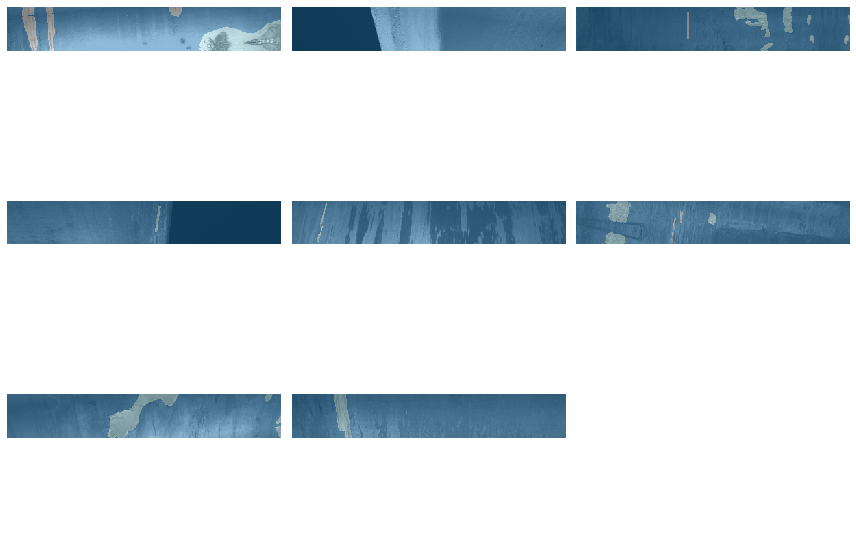

In [112]:
data.show_batch(3, figsize=(12,9))

## Create Learner

In [26]:
print(bs, size)

40 [ 32 200]


In [37]:
arch = models.resnet50

In [41]:
# Reference: @lafoss on Kaggle - Kernel - Severstal: fast.ai 256x256 crops
def dice_score(input:Tensor, targs:Tensor, iou:bool=False, eps:float=1e-8)->Rank0Tensor:
    n,c = targs.shape[0], input.shape[1]
    input = input.argmax(dim=1).view(n,-1)
    targs = targs.view(n,-1)
    intersect,union = [],[]
    for i in range(1,c):
        intersect.append(((input==i) & (targs==i)).sum(-1).float())
        union.append(((input==i).sum(-1) + (targs==i).sum(-1)).float())
    intersect = torch.stack(intersect)
    union = torch.stack(union)
    if not iou: return ((2.0*intersect + eps) / (union+eps)).mean()
    else: return ((intersect + eps) / (union - intersect + eps)).mean()

In [42]:
# # Dice from legend
# # Reference: @Musa Atlıhan on Fast.ai forum https://forums.fast.ai/t/training-unet-dice-coefficient-1-for-segmentation/56195/3
# def dice_(input:Tensor, targs:Tensor, iou:bool=False, eps:float=1e-8)->Rank0Tensor:
#     n = targs.shape[0]
#     dice_sum = torch.as_tensor([0.], dtype=torch.float32, device=targs.device)
#     for i in range(1, targs.max()+1):
#         input_flatten = input[:,i-1,:,:].flatten(1,-1).float()
#         targs_flatten = targs.flatten(1,-1).float()
#         input_flatten[input_flatten>0.5], input_flatten[input_flatten<=0.5] = 1., 0.
#         targs_flatten[targs_flatten!=i], targs_flatten[targs_flatten==i] = 0, 1
#         intersect = (input_flatten * targs_flatten).sum(dim=1)
#         union = (input_flatten + targs_flatten).sum(dim=1)
#         if not iou: l = 2. * intersect / union
#         else: l = intersect / (union-intersect+eps)
#         l[union == 0.] = 1
#         dice_sum += l.mean()
#     return dice_sum / targs.max()

In [43]:
dice_custom = partial(dice_score, iou=False)

In [43]:
learn = unet_learner(data, arch, metrics=[dice_custom], wd=1e-2, bottle=True)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /home/ubuntu/.cache/torch/checkpoints/resnet50-19c8e357.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 132MB/s]


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


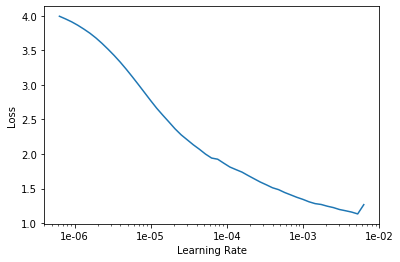

In [44]:
lr_find(learn)
learn.recorder.plot()

In [45]:
lr=1e-05

In [46]:
print(lr)

1e-05


In [47]:
learn.fit_one_cycle(10, slice(lr))

epoch,train_loss,valid_loss,dice_score,time
0,0.208783,0.146311,0.610338,01:56
1,0.113148,0.095584,0.793973,01:54
2,0.099528,0.088376,0.826638,01:55
3,0.087339,0.083003,0.826596,01:54
4,0.082165,0.074077,0.848864,01:55
5,0.078760,0.071946,0.856653,01:54
6,0.074250,0.069963,0.861388,01:54
7,0.073612,0.068874,0.865570,01:55
8,0.071966,0.068628,0.866256,01:55
9,0.070955,0.068505,0.864926,01:55


In [48]:
learn.save('stage-1-rn50')

In [49]:
learn.load('stage-1-rn50');

In [50]:
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


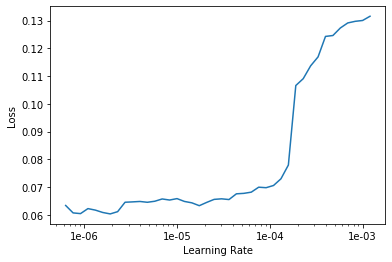

In [51]:
learn.lr_find()
learn.recorder.plot()

In [96]:
# Pick a value just before the slope goes upward, then 10x smaller
# 1e-05 --> 1e-06

In [52]:
lrs = slice(1e-05, lr/5)

In [53]:
# LR / 5 or LR / 10 - Discriminate learning
learn.fit_one_cycle(12, lrs)

epoch,train_loss,valid_loss,dice_score,time
0,0.070057,0.068262,0.866984,01:57
1,0.069537,0.068805,0.865449,01:56
2,0.066486,0.068475,0.870153,01:58
3,0.069268,0.068159,0.867714,01:57
4,0.071131,0.066765,0.870318,01:57
5,0.067234,0.067578,0.870419,01:57
6,0.067616,0.066358,0.867231,01:57
7,0.065557,0.065209,0.872856,01:57
8,0.062295,0.065284,0.873989,01:57
9,0.066560,0.065285,0.875091,01:57


In [54]:
learn.save('stage-2-rn50')

In [23]:
learn=None
gc.collect()

2386

In [24]:
import torch
torch.cuda.empty_cache()

In [36]:
# size = size*2
bs=8

In [37]:
print(bs, size)

8 [ 64 400]


In [38]:
# Resize data
data = (src.transform(get_transforms(), size=size, tfm_y=True)
        .databunch(bs=bs).normalize(imagenet_stats))

In [39]:
learn = unet_learner(data, arch, metrics=[dice_custom], wd=1e-2, bottle=True).load('stage-2-rn50');

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


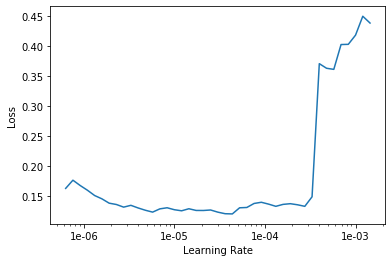

In [40]:
learn.lr_find()
learn.recorder.plot()

In [41]:
lr=1e-04

In [42]:
lrs = slice(1e-05, lr/5)

In [43]:
learn.fit_one_cycle(10, lrs)

epoch,train_loss,valid_loss,dice_score,time
0,0.072450,0.068563,0.843465,08:18
1,0.079882,0.081780,0.810393,08:19
2,0.073705,0.068878,0.881465,08:18
3,0.080040,0.065684,0.877838,08:19
4,0.065837,0.066392,0.872508,08:18
5,0.054296,0.056869,0.886811,08:19
6,0.052602,0.056769,0.894585,08:19
7,0.057566,0.054602,0.904486,08:19
8,0.053440,0.052930,0.904526,08:18
9,0.043150,0.053283,0.901108,08:20


In [45]:
learn.save('stage-3-rn50');

In [ ]:
learn=None
gc.collect()

In [34]:
import torch
torch.cuda.empty_cache()

In [ ]:
size = size*2
bs=4

In [ ]:
print(bs, size)

In [116]:
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


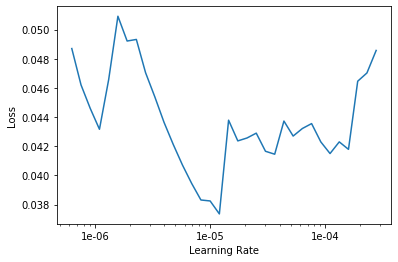

In [117]:
learn.lr_find()
learn.recorder.plot()

In [27]:
size = size*2
bs=4

In [28]:
print(bs, size)

4 [128 800]


In [32]:
# Resize data
data = (src.transform(get_transforms(), size=size, tfm_y=True)
        .databunch(bs=bs).normalize(imagenet_stats))

In [47]:
learn = unet_learner(data, arch, metrics=[dice_custom], wd=1e-2, bottle=True).load('stage-3-rn50');

In [48]:
learn.lr_find()
learn.recorder.plot()

In [53]:
lrs = slice(1e-05, lr/10)

In [ ]:
learn.fit_one_cycle(10, slice(lr))

epoch,train_loss,valid_loss,dice_score,time
0,0.078192,0.058514,0.866480,29:10
1,0.098950,0.068481,0.860149,29:06
2,0.080659,0.063829,0.879897,28:55
3,0.066638,0.052243,0.893228,28:46
4,0.078166,0.226818,0.816769,28:45


In [ ]:
learn.recorder.plot_losses()

In [ ]:
learn.save('stage-4-rn50')

In [ ]:
learn.path = path

In [ ]:
learn.path

In [ ]:
learn.export()

In [95]:
# Exports
##############
# 10/10/2019 1:53pm - ResNet34
# Stage 1 - 64 x 400 
# Stage 2 - 64 x 400
# Stage 3 - 128 X 800
##############
# 10/10/2019 5:08pm - ResNet34
# Stage 1 - 64 x 400 
# Stage 2 - 64 x 400
# Stage 3 - 64 X 400

##############
# 12/10/2019 4:40pm - ResNet50
# Stage 1 - 64 x 400 
# Stage 2 - 64 x 400
# Stage 3 - 64 X 400

## Inference

In [53]:
tnames = get_image_files(path_test)
tnames[:5]

[PosixPath('/home/ubuntu/.fastai/data/severstal-steel-defect-detection/test_images/73d60f24f.jpg'),
 PosixPath('/home/ubuntu/.fastai/data/severstal-steel-defect-detection/test_images/f99381ed5.jpg'),
 PosixPath('/home/ubuntu/.fastai/data/severstal-steel-defect-detection/test_images/c4405bef9.jpg'),
 PosixPath('/home/ubuntu/.fastai/data/severstal-steel-defect-detection/test_images/b991340c8.jpg'),
 PosixPath('/home/ubuntu/.fastai/data/severstal-steel-defect-detection/test_images/1ba63ec01.jpg')]

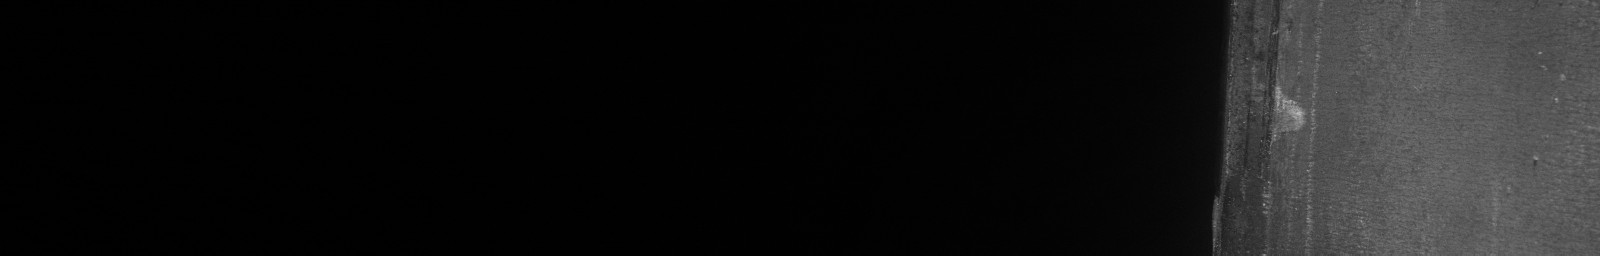

In [54]:
# Sample test image
img = open_image(path_test/'f99381ed5.jpg')
img

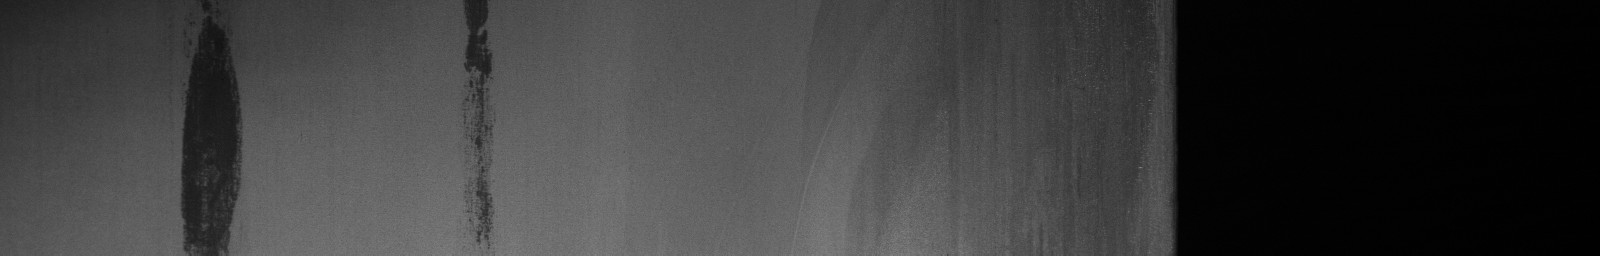

In [55]:
open_image(tnames[0])

In [64]:
# Setup test data
# test_data = ItemList.from_folder(path/'test_images')

In [65]:
# Load learner
# learn = load_learner(path, test=test_data, tfm_y=False)

In [66]:
learn = load_learner(path)

learn.data.valid_ds.tfms = [RandTransform(tfm=TfmCrop (crop_pad), kwargs={}, p=1.0, resolved={'padding_mode': 'reflection', 'row_pct': 0.5, 'col_pct': 0.5}, do_run=True, is_random=True, use_on_y=False)]
learn.data.valid_ds.tfms_y = [RandTransform(tfm=TfmCrop (crop_pad), kwargs={}, p=1.0, resolved={'padding_mode': 'reflection', 'row_pct': 0.5, 'col_pct': 0.5}, do_run=True, is_random=True, use_on_y=False)]
test_data = SegmentationItemList.from_folder(path/'test_images')
learn.data.add_test(test_data)

In [67]:
# Predict
preds, _ = learn.get_preds(ds_type=DatasetType.Test)

In [68]:
#https://www.kaggle.com/paulorzp/rle-functions-run-lenght-encode-decode
def mask2rle(img):
    '''
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    pixels= img.T.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

In [69]:
def post_process(probability, threshold, min_size):
    '''Post processing of each predicted mask, components with lesser number of pixels
    than `min_size` are ignored'''
    mask = cv2.threshold(probability.cpu().data.numpy(), threshold, 1, cv2.THRESH_BINARY)[1]
    num_component, component = cv2.connectedComponents(mask.astype(np.uint8))
    predictions = np.zeros((64, 400), np.float32)
    num = 0
    for c in range(1, num_component):
        p = (component == c)
        if p.sum() > min_size:
            predictions[p] = 1
            num += 1
    return predictions, num

In [71]:
def get_rle(pred, thresh=0.5, min_size=100, scale=4):
    '''Get RLEs'''
    pred_mask, test_num = post_process(pred, thresh, min_size=min_size)
    pred_mask = pred_mask.repeat(scale, axis=0).repeat(scale, axis=1)
    rle  = mask2rle(pred_mask)
    return rle

In [72]:
min_size = 100

In [73]:
learn.data.classes

[0, 1, 2, 3, 4]

In [74]:
src_size

array([ 256, 1600])

In [75]:
fnames = [('_'.join([i.name, str(c)])) for i in learn.data.test_ds.items for c in learn.data.classes]

In [91]:
preds_list = [get_rle(j, thresh=0.6, min_size=100) for pred in preds for _,j in enumerate(pred)]

In [92]:
df = pd.DataFrame({'ImageId_ClassId':fnames, 'EncodedPixels':preds_list}, columns=['ImageId_ClassId', 'EncodedPixels'])

In [93]:
df = df[~df.ImageId_ClassId.str.contains("_0")]

In [94]:
df.head()

,ImageId_ClassId,EncodedPixels
1,73d60f24f.jpg_1,
2,73d60f24f.jpg_2,
3,73d60f24f.jpg_3,
4,73d60f24f.jpg_4,
6,f99381ed5.jpg_1,


In [95]:
# ! cp 'home/ubuntu/.fastai/data/severstal-steel-defect-detection/export.pkl' 'export.pkl'

In [96]:
df.to_csv('submission.csv', index=False)